Colab Link: https://colab.research.google.com/drive/1tU4Leou1F6XDVlBaLfBphWTL43-BPV_d

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = "cs231n-project"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


# Load Dataset and create Train/Test Split

In [ ]:
dataset_path = f"/content/drive/My Drive/cs231n-project/dataset/Taskent"

dataset_size = 21
test_indices = [1,2]
train_indices = [i for i in range(dataset_size) if not i in test_indices]
# train_indices = [0,3,4]

In [ ]:
from image_dataset import *


train_dataset = PetroSubImageDataset(dataset_path, image_indices=train_indices)
test_dataset = PetroSubImageDataset(dataset_path, image_indices=test_indices)

__init__ PetroSubImageDataset: /content/drive/My Drive/cs231n-project/dataset/Taskent
         , image_indices=[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
         , sub_image_size=480
__init__ BaseSubImageDataset with: /content/drive/My Drive/cs231n-project/dataset/Taskent/img
         , image_indices=[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
         , sub_image_size=480
         , mask=False
__init__ BaseSubImageDataset with: /content/drive/My Drive/cs231n-project/dataset/Taskent/masks_machine
         , image_indices=[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
         , sub_image_size=480
         , mask=True


/content/drive/My Drive/cs231n-project/image_dataset.py:211: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  images = torch.stack([torch.from_numpy(img) for img in images])


__init__ PetroSubImageDataset: /content/drive/My Drive/cs231n-project/dataset/Taskent
         , image_indices=[1, 2]
         , sub_image_size=480
__init__ BaseSubImageDataset with: /content/drive/My Drive/cs231n-project/dataset/Taskent/img
         , image_indices=[1, 2]
         , sub_image_size=480
         , mask=False
__init__ BaseSubImageDataset with: /content/drive/My Drive/cs231n-project/dataset/Taskent/masks_machine
         , image_indices=[1, 2]
         , sub_image_size=480
         , mask=True


# Set device to use GPU if available

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
!nvidia-smi

Tue Jun  3 07:04:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             48W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Load DINO Model

In [ ]:
# Load smallest dino model. ViT-S/8. Here ViT-S has ~22M parameters and
# works on 8x8 patches.
dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
dino_model.eval().to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

# Loop through DINO for all training data

In [ ]:
from torch.utils.data import DataLoader
from clip_dino import DINOSegmentation, compute_iou
from dino_model import DINOImageClassifier
from tqdm import tqdm

In [ ]:
from torchvision import transforms as T

transform = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# transform = T.Compose([
#     # T.Resize((480, 480)),
#     T.ToTensor(),
#     T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# ])


In [ ]:

# def get_dino_tokens(sample_image):
#     img_tensor = transform(sample_image)
#     # (3,480,480)
#     w, h = img_tensor.shape[1:]
#     img_tensor = img_tensor[None].to(device)
#     # (1,3,480,480)

#     with torch.no_grad():
#         attn = dino_model.get_last_selfattention(img_tensor)[0, :, 0, 1:]
#         # (6,3600)
#         nh, tokens = attn.shape
#         w_feat, h_feat = w // 8, h // 8
#         attn = attn.reshape(nh, w_feat, h_feat)
#         attn = torch.nn.functional.interpolate(attn.unsqueeze(0), scale_factor=8, mode="nearest")[0].cpu().numpy()
#         all_tokens = dino_model.get_intermediate_layers(img_tensor, n=1)[0]  # (1, 1+N, D)
#     # pprint(all_tokens)
#     return all_tokens.cpu()

def get_dino_tokens_batch(X_batch):

    # X_batch.shape = [batch_size,480,480,3]

    X_batch = X_batch.float() / 255.0 # normalize
    # X_batch = X_batch.permute(0,3,1,2) # [N,H,W,C] -> [N,C,H,W]
    X_transform = torch.stack([
        transform(x) for x in X_batch
    ])
    X_transform = X_transform.to(device)

    w, h = X_transform.shape[2:]
    # 480,480

    with torch.no_grad():
        attn = dino_model.get_last_selfattention(X_transform)[:, :, 0, 1:]
        # (N,6,3600)
        # print(f"attn.shape={attn.shape}")
        nh, tokens = attn.shape[1:]
        w_feat, h_feat = w // 8, h // 8
        attn = attn.reshape(-1, nh, w_feat, h_feat)
        attn = torch.nn.functional.interpolate(attn, scale_factor=8, mode="nearest").cpu().numpy()
        all_tokens = dino_model.get_intermediate_layers(X_transform, n=1)[0]  # (N, 1+pixels, D)
    return all_tokens.cpu()

In [ ]:
# How to convert from 480x480x1 to 1
def get_Y_labels(Y_batch):
    # input (N,480,480)
    # output (N)

    # print(Y_batch.shape)

    # use most common pixel classification for training
    Y_batch_modes = torch.stack([
        torch.bincount(Y_batch[i].flatten()).argmax()
        for i in range(Y_batch.shape[0])
    ])

    return Y_batch_modes

## test get_Y_labels

# train_indices = [i for i in range(10)] # 10 images
# train_dataset = PetroSubImageDataset_v2(dataset_path, image_indices=train_indices)

# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=7
# )
# batch = next(iter(train_dataloader))
# print(batch.shape)
# X_batch = batch[:,:-1]
# Y_batch = batch[:,-1]
# print(X_batch.shape,Y_batch.shape)
# print(get_Y_labels(Y_batch))

In [ ]:
num_classes = 18
batch_size = 32
num_iters = 20
hidden_dim = 768

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size
)

model = DINOImageClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for iter in range(num_iters):

    ### TRAINING ###

    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    pbar = tqdm(train_dataloader, desc=f"Train Epoch {iter+1}/{num_iters}")
    for batch in pbar:

        X_batch = batch[:,:-1]
        Y_batch = batch[:,-1]

        Y_labels = get_Y_labels(Y_batch).to(device)
        # print(f"X: {X_batch.shape}, Y: {Y_labels.shape}")

        with torch.no_grad():
            X_tokens = get_dino_tokens_batch(X_batch) # [N, 3601, D=384]
            X_tokens = X_tokens[:, 1:, :]  # (N, 3600, D) # uncomment to drop CLS token

        # print(f"X: {X_batch.shape}->{X_tokens.shape}, Y: {Y_batch.shape}->{Y_labels.shape}")

        X = X_tokens.to(device)
        Y = Y_labels.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, Y)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        total_train_loss += batch_loss

        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == Y).sum().item()
        total_train += Y.size(0)

        pbar.set_postfix(loss=f"{batch_loss:.2f}")

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    # print(f"Epoch {iter+1}: Train Loss={avg_train_loss:.2f}, Accuracy={train_accuracy:.2f}")

    ### VALIDATION ###

    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():

        pbar = tqdm(test_dataloader, desc=f"Val Epoch {iter+1}/{num_iters}")

        for batch in pbar:
            X_batch = batch[:, :-1]
            Y_batch = batch[:, -1]
            Y_labels = get_Y_labels(Y_batch).to(device)

            X_tokens = get_dino_tokens_batch(X_batch) # [N, 3601, D=384]
            X_tokens = X_tokens[:, 1:, :]  # (N, 3600, D) # uncomment to drop CLS token
            X = X_tokens.to(device)
            Y = Y_labels.to(device)

            logits = model(X)
            loss = loss_fn(logits, Y)
            val_loss = loss.item()
            total_val_loss += val_loss

            preds = torch.argmax(logits, dim=1)
            correct_val += (preds == Y).sum().item()
            total_val += Y.size(0)

            pbar.set_postfix(loss=f"{val_loss:.2f}")

    avg_val_loss = total_val_loss / len(test_dataloader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    # print(f"Epoch {iter+1}: Val Loss={avg_val_loss:.2f}, Accuracy={val_accuracy:.2f}")

    print()

    print(f"Epoch {iter+1}: Train Loss={avg_train_loss:.2f}, Accuracy={train_accuracy:.2f} // Val Loss={avg_val_loss:.2f}, Accuracy={val_accuracy:.2f}")



Val Epoch 1/20: 100%|██████████| 3/3 [00:09<00:00,  3.28s/it, loss=0.63]



Epoch 1: Train Loss=3.12, Accuracy=0.59 // Val Loss=1.06, Accuracy=0.92


Val Epoch 2/20: 100%|██████████| 3/3 [00:09<00:00,  3.28s/it, loss=0.17]



Epoch 2: Train Loss=1.04, Accuracy=0.60 // Val Loss=0.85, Accuracy=0.92


Val Epoch 3/20: 100%|██████████| 3/3 [00:09<00:00,  3.28s/it, loss=0.17]



Epoch 3: Train Loss=1.10, Accuracy=0.63 // Val Loss=1.86, Accuracy=0.73


Val Epoch 4/20: 100%|██████████| 3/3 [00:09<00:00,  3.29s/it, loss=0.39]



Epoch 4: Train Loss=1.24, Accuracy=0.63 // Val Loss=1.29, Accuracy=0.91


Val Epoch 5/20: 100%|██████████| 3/3 [00:09<00:00,  3.28s/it, loss=0.18]



Epoch 5: Train Loss=0.95, Accuracy=0.62 // Val Loss=1.29, Accuracy=0.92


Val Epoch 6/20: 100%|██████████| 3/3 [00:09<00:00,  3.28s/it, loss=0.45]



Epoch 6: Train Loss=0.90, Accuracy=0.61 // Val Loss=2.31, Accuracy=0.76


Val Epoch 7/20: 100%|██████████| 3/3 [00:09<00:00,  3.29s/it, loss=0.22]



Epoch 7: Train Loss=0.88, Accuracy=0.60 // Val Loss=2.24, Accuracy=0.69


Val Epoch 8/20: 100%|██████████| 3/3 [00:09<00:00,  3.28s/it, loss=0.32]



Epoch 8: Train Loss=0.87, Accuracy=0.62 // Val Loss=2.05, Accuracy=0.70


Val Epoch 9/20: 100%|██████████| 3/3 [00:09<00:00,  3.28s/it, loss=0.36]



Epoch 9: Train Loss=0.76, Accuracy=0.65 // Val Loss=2.45, Accuracy=0.62


Val Epoch 10/20: 100%|██████████| 3/3 [00:09<00:00,  3.28s/it, loss=0.96]



Epoch 10: Train Loss=0.81, Accuracy=0.66 // Val Loss=4.00, Accuracy=0.11


Val Epoch 11/20: 100%|██████████| 3/3 [00:09<00:00,  3.28s/it, loss=0.65]



Epoch 11: Train Loss=0.89, Accuracy=0.62 // Val Loss=2.85, Accuracy=0.49


Val Epoch 12/20: 100%|██████████| 3/3 [00:09<00:00,  3.28s/it, loss=0.55]



Epoch 12: Train Loss=0.73, Accuracy=0.68 // Val Loss=2.46, Accuracy=0.60


Train Epoch 13/20:  83%|████████▎ | 24/29 [01:19<00:16,  3.31s/it, loss=0.05]

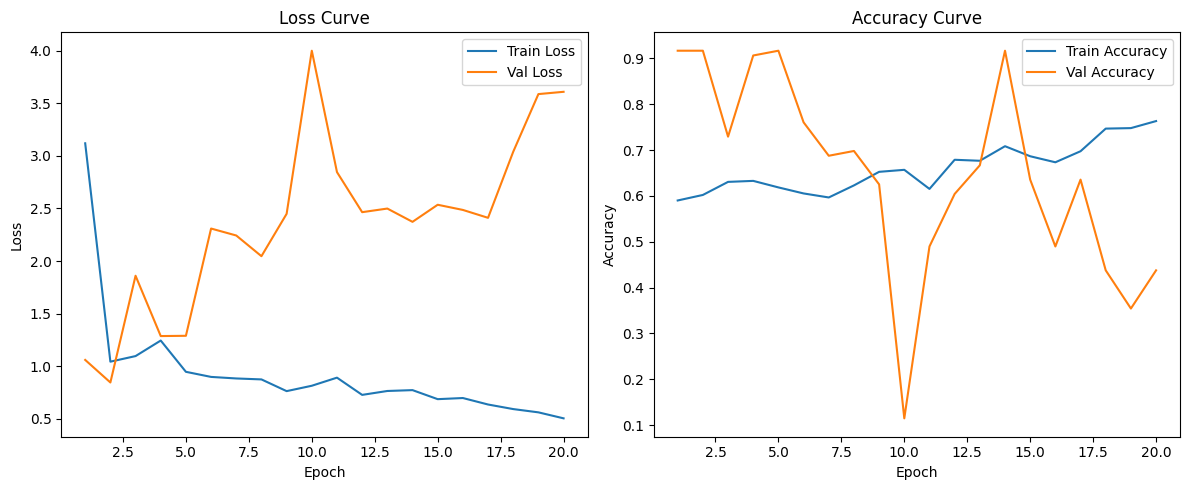

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_iters + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
val_losses